In [13]:
#import sympy
import scanpy as sc
import scanpy.external as sce
import pandas as pd
from scipy.io import mmread
import harmonypy as hm
import numpy as np
import matplotlib.pyplot as plt
import scvi
import pandas as pd
import seaborn as sns

sc.settings.verbosity = 2
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10


In [2]:
# Construct an object using 10x data
# Data source: https://figshare.com/ndownloader/files/35600003
# Unzip data if needed
# Replace these paths with the actual paths to the four files
matrix_file = 'example/data/'  # Update to the directory containing the matrix files
barcodes_file = 'example/data/barcodes.tsv'
genes_file = 'example/data/genes.tsv'
metadata_file = 'example/data/metadata.csv.zip'

# Check the head of the metadata
metadata_head = pd.read_csv(metadata_file, compression='zip', nrows=5)
print(metadata_head)

# Read 10x Genomics data using Scanpy
adata = sc.read_10x_mtx(matrix_file, var_names='gene_symbols', cache=True)

# Read additional metadata
metadata = pd.read_csv(metadata_file, compression='zip', index_col='Unnamed: 0')

# Update AnnData with barcodes, genes, and additional metadata
adata.obs_names = pd.read_csv(barcodes_file, header=None, names=['CellID']).squeeze()
adata.var_names = pd.read_csv(genes_file, sep='\t', header=None, names=['GeneID', 'GeneSymbol'], index_col=0)['GeneSymbol']
adata.obs = metadata.loc[adata.obs_names]

# Save AnnData object
adata.write('adata.h5ad')

# Print the AnnData object
print(adata)

            Unnamed: 0 PatientID  NormalvsTumor
0  GCGACCACAAGCTGTT-11        P3              0
1  CTAATGGAGTCCGTAT-49       P12              1
2  ACGCAGCCAGAGTGTG-29        P7              1
3   GTTCATTAGTTGCAGG-9        P2              1
4  ATCGAGTCAATGTTGC-18        P4              1
... reading from cache file cache\example-data-matrix.h5ad
AnnData object with n_obs × n_vars = 4276224 × 33694
    obs: 'PatientID', 'NormalvsTumor'
    var: 'gene_ids'


D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:00)


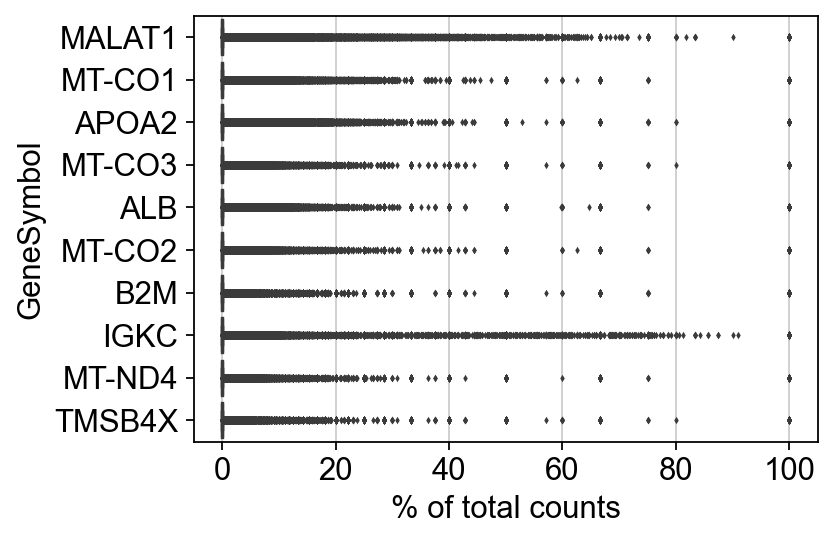

AnnData object with n_obs × n_vars = 4276224 × 33694
    obs: 'PatientID', 'NormalvsTumor'
    var: 'gene_ids'

In [3]:
# Read the adata object
adata = sc.read('adata.h5ad')
sc.pl.highest_expr_genes(adata, n_top=10) 
adata

filtered out 4264933 cells that have less than 200 genes expressed
filtered out 13431 genes that are detected in less than 3 cells


D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


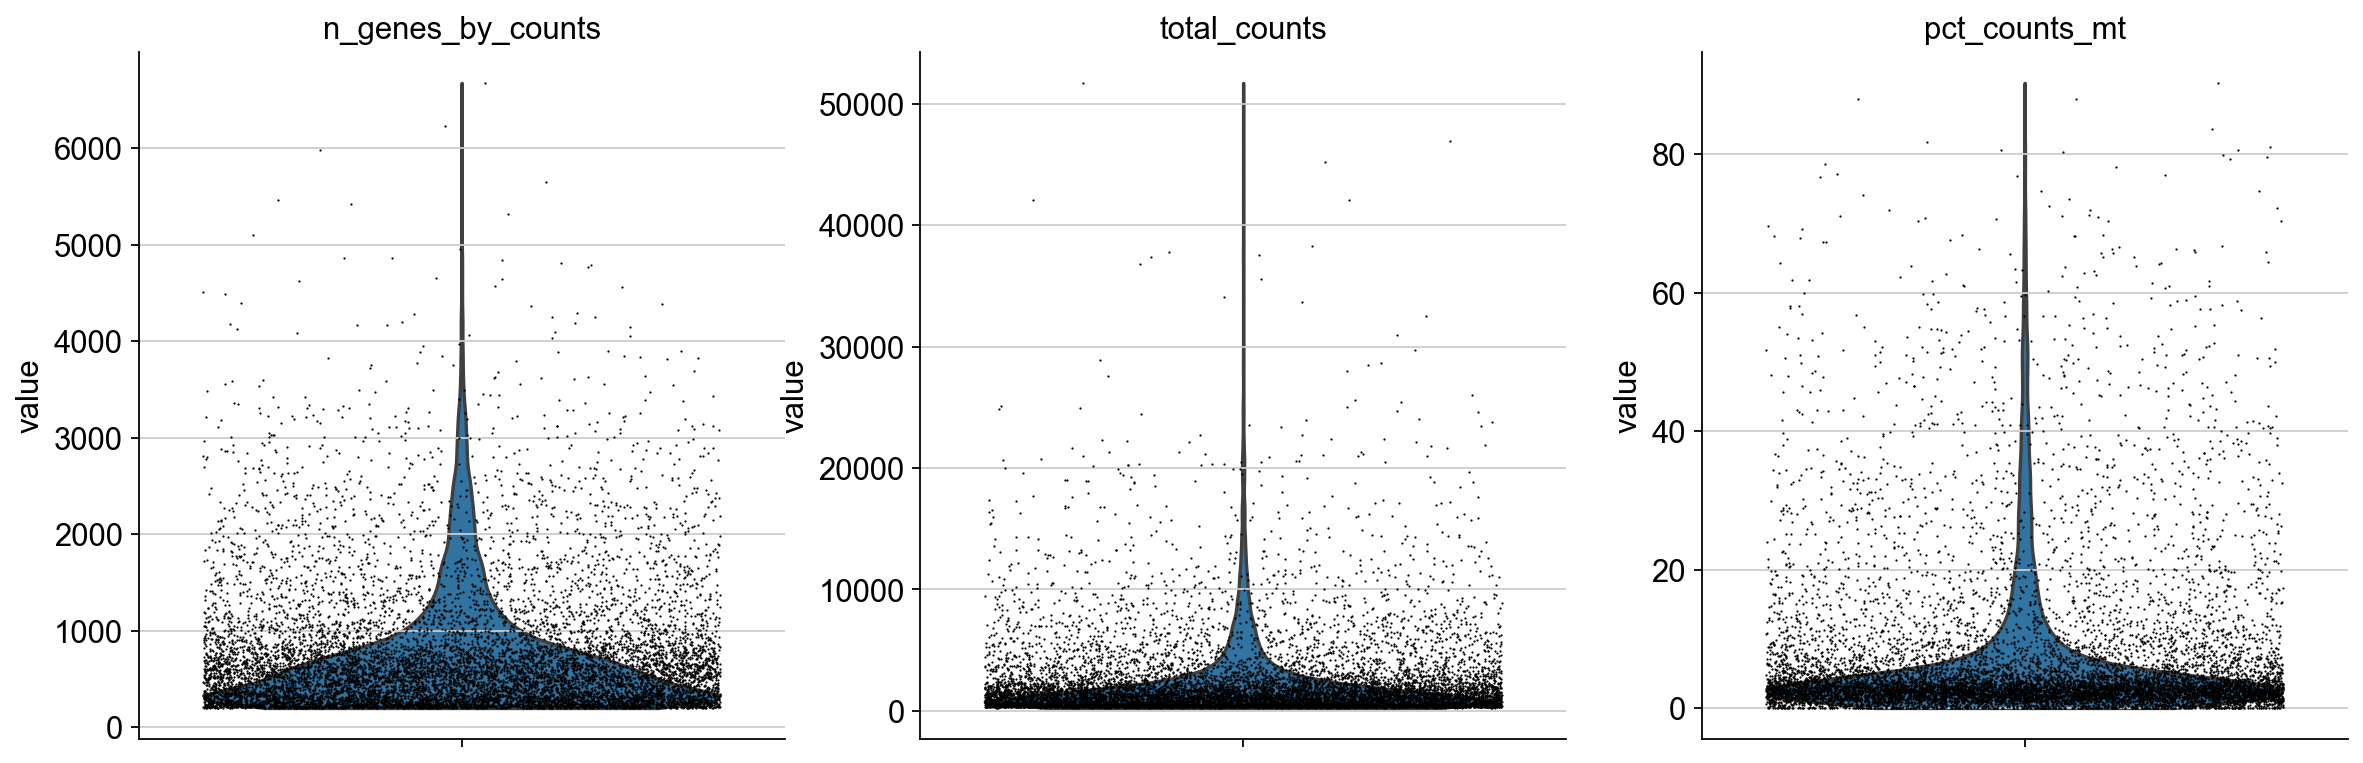

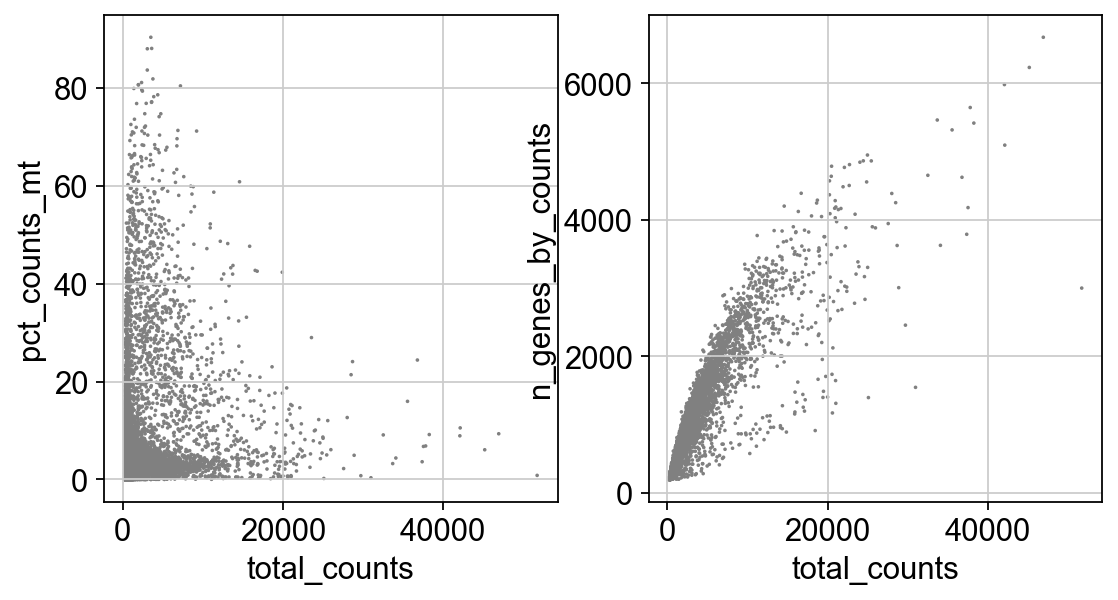

In [4]:
# Basic quanlity check and filtering
adata.var_names_make_unique()

# Basic filtering:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate mt gene percentages
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot violin plots
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Draw scatter plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjust the figsize as needed
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[1], show=False)
plt.show()

D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


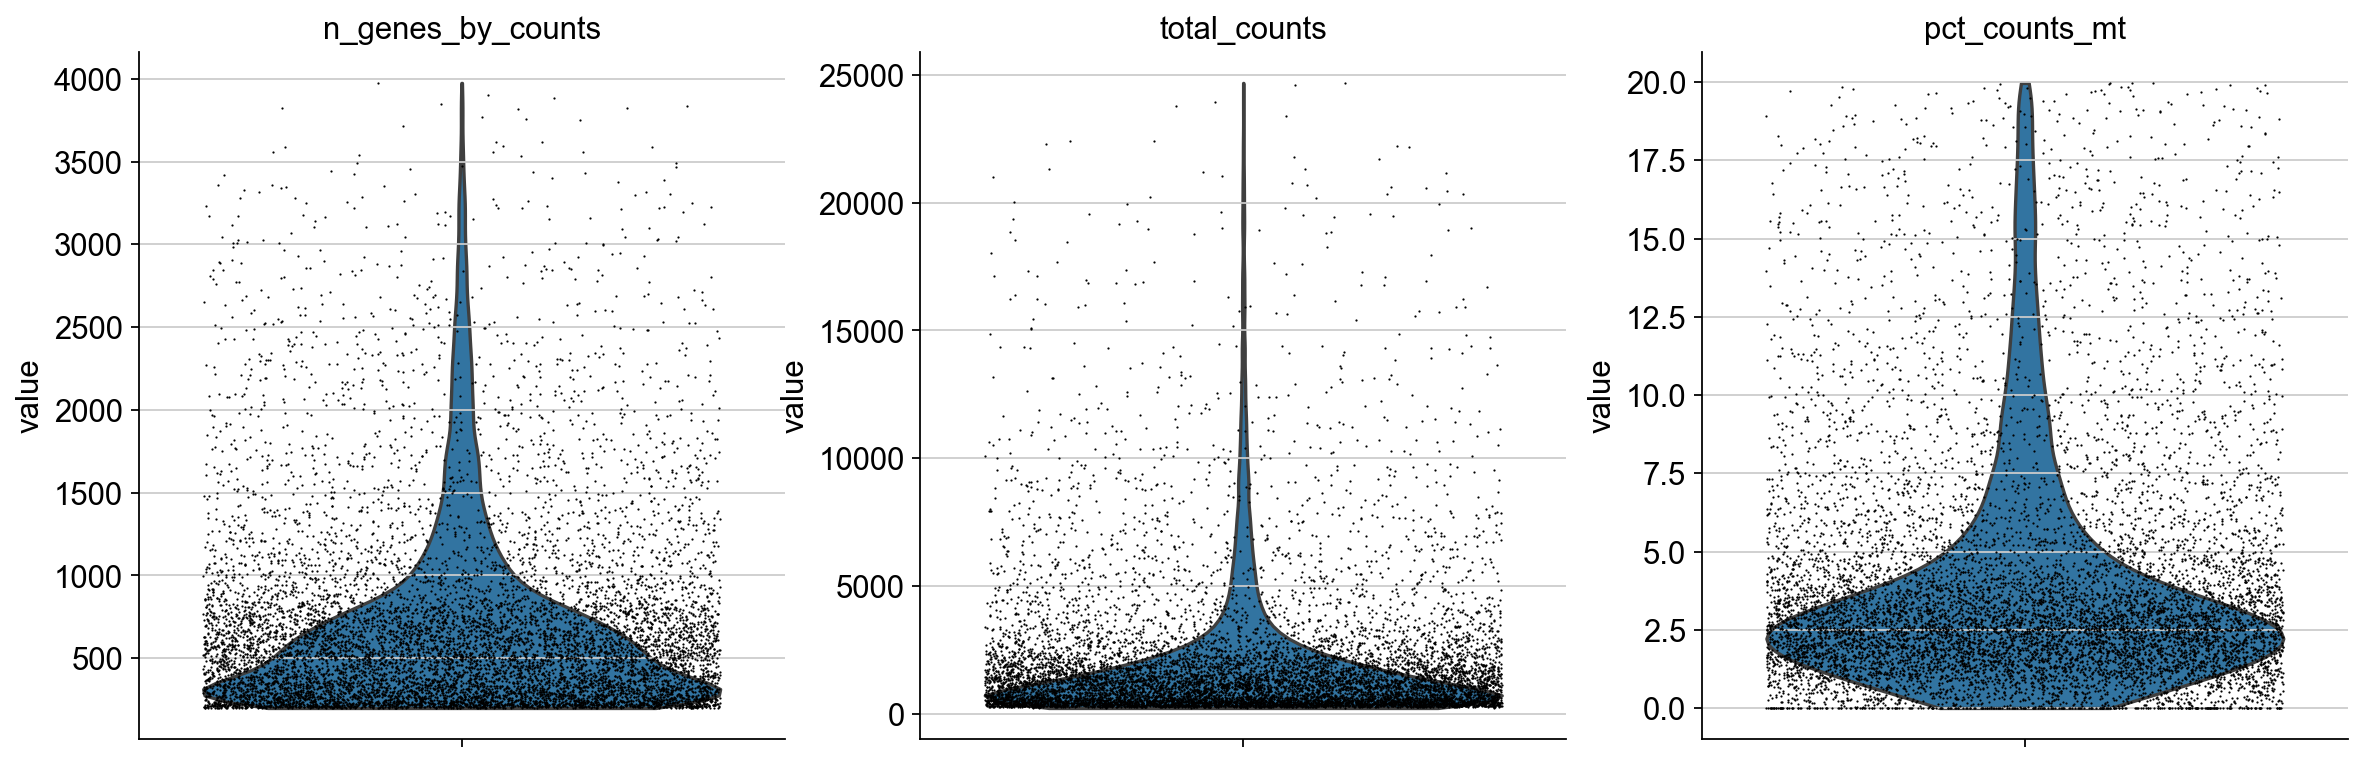

In [5]:
# Manual filtering
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 25000,:]

# view again
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [7]:
# Freeze the raw data after QC
adata.raw = adata
# Create a layer of counts
adata.layers["counts"] = adata.X.copy()
adata
adata.write("adata1_filtered_unnorm.h5ad")

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


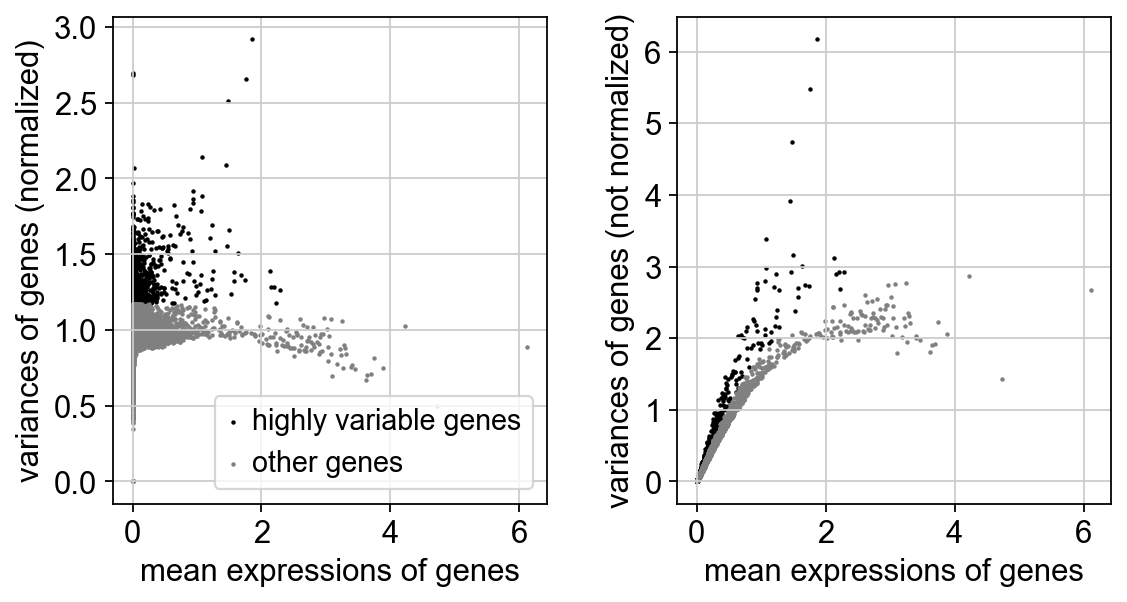

In [8]:
# Generate the PCA
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:27)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


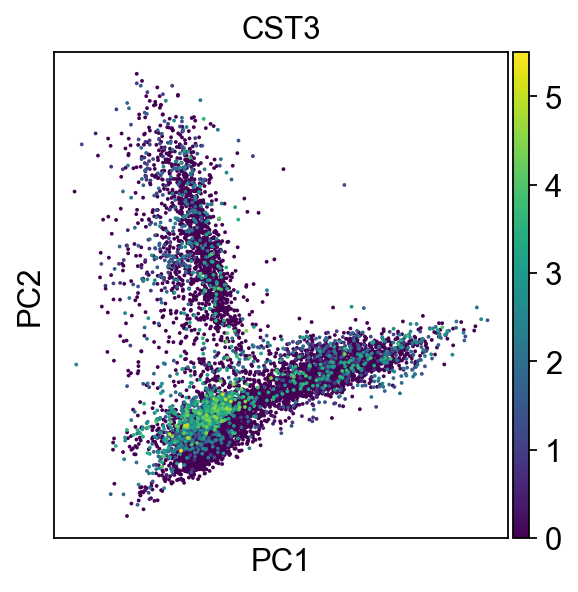

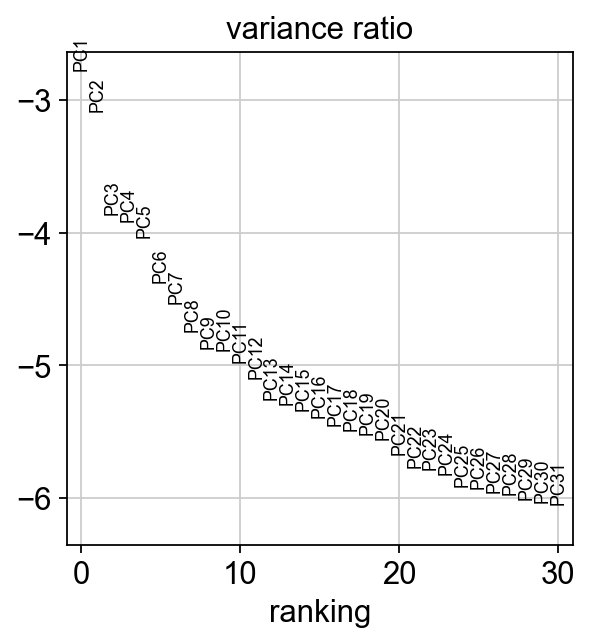

In [9]:
# adata.raw = adata
# Regress Out Unwanted Sources of Variation before scaling
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'], n_jobs = 3)

# Scale using the parallel backend
#adata.X = adata.X.toarray()  # Ensure data is dense for parallel scaling
#adata = adata.parallelize(adata.uns['neighbors']['params']['n_jobs'])
#adata.X = adata.X.astype('float32', copy=False)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

In [10]:
# Save AnnData object
adata.write('adata2.h5ad')

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
D:\WPy64-31090\python-3.10.9.amd64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


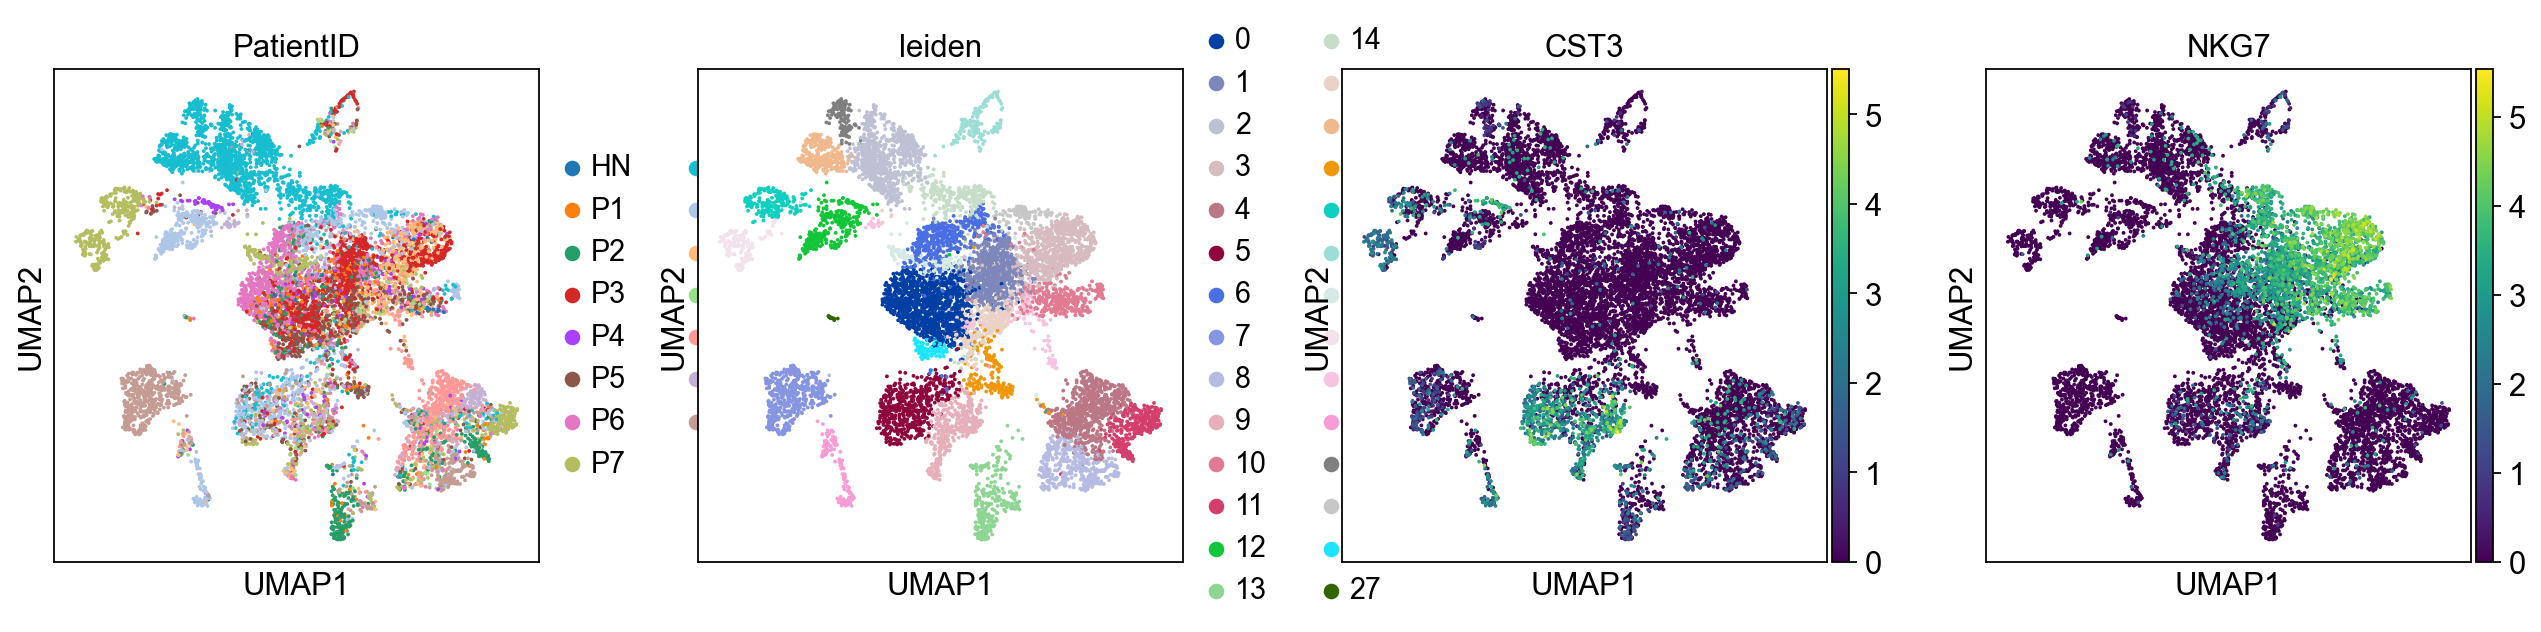

In [11]:
# Generate the umap
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

#Embedding the neighborhood graph
sc.tl.leiden(adata)  # required by the following paga function
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])
## sc.pl.umap(adata, color=['CST3', 'NKG7', 'PatientID'], use_raw=False)

# Save the result.
adata.write('adata3.h5ad')

In [9]:
# Read the adata object
adata = sc.read('adata3.h5ad')
adata

AnnData object with n_obs × n_vars = 10203 × 20263
    obs: 'PatientID', 'NormalvsTumor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

2023-12-05 20:36:11,272 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-05 20:36:16,395 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-05 20:36:16,486 - harmonypy - INFO - Iteration 1 of 10
2023-12-05 20:36:22,952 - harmonypy - INFO - Iteration 2 of 10
2023-12-05 20:36:29,144 - harmonypy - INFO - Iteration 3 of 10
2023-12-05 20:36:35,857 - harmonypy - INFO - Iteration 4 of 10
2023-12-05 20:36:41,507 - harmonypy - INFO - Iteration 5 of 10
2023-12-05 20:36:45,335 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


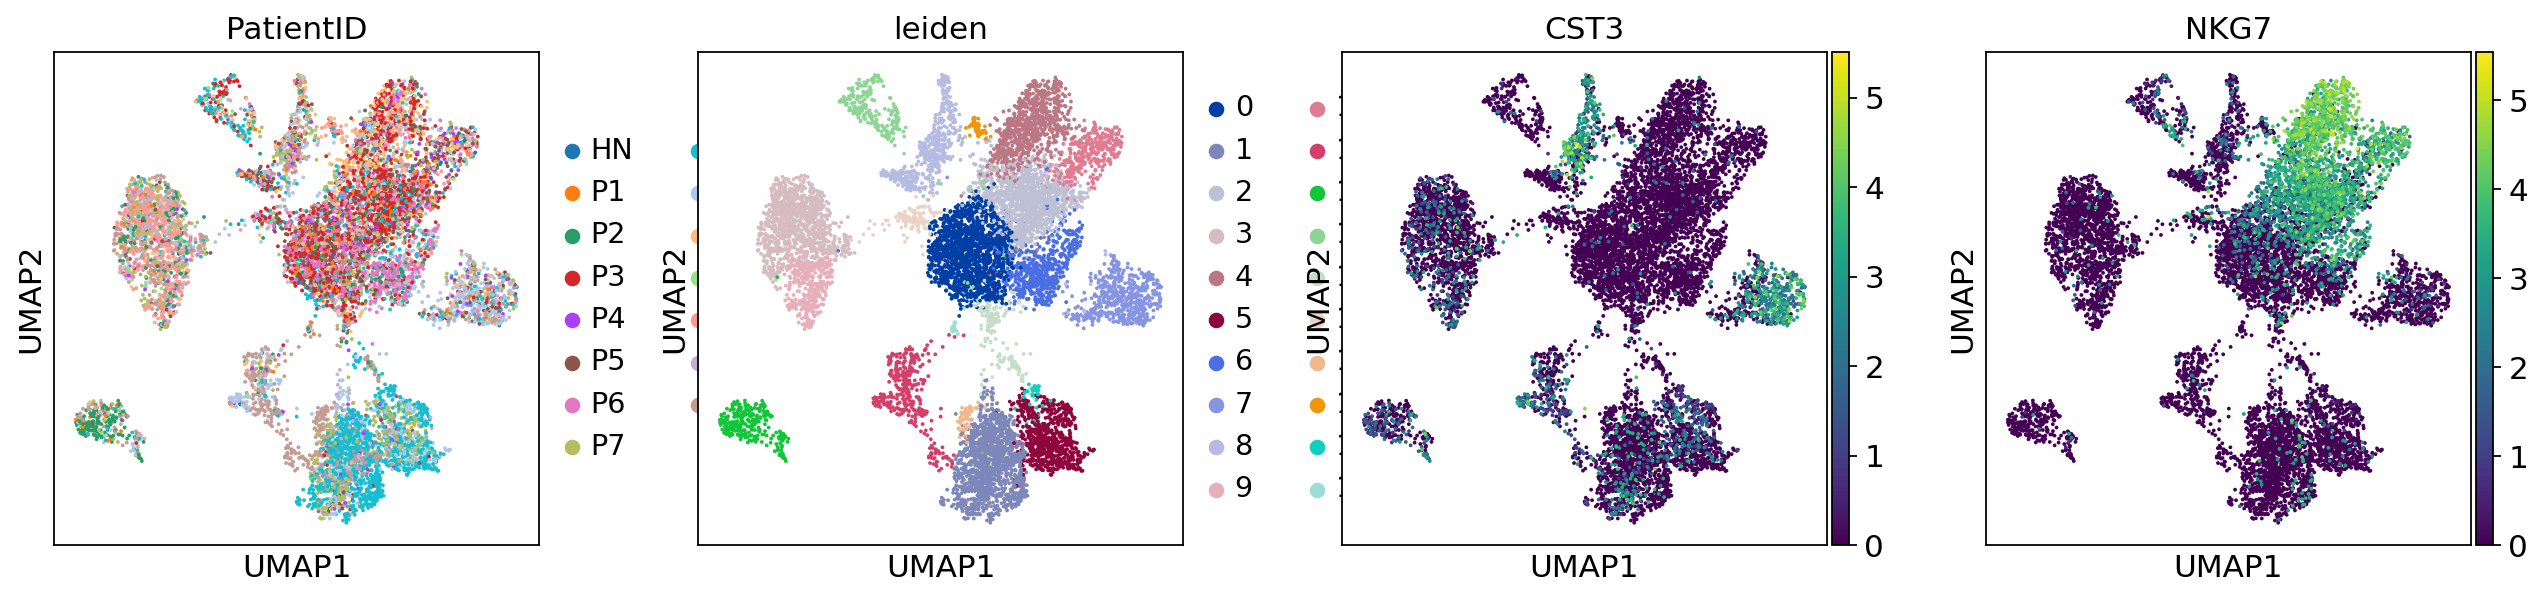

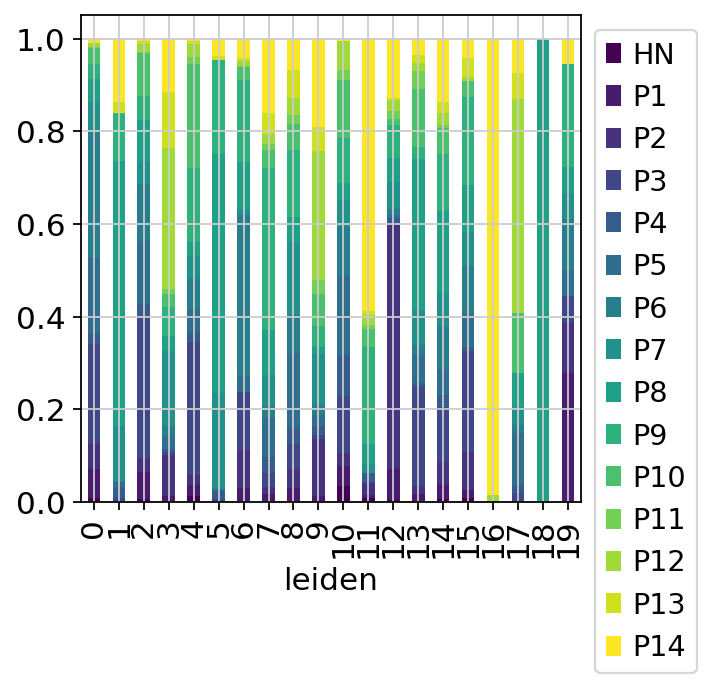

In [6]:
# Batch correction option: Harmony
adata = sc.read('adata3.h5ad')
sce.pp.harmony_integrate(adata, 'PatientID')
adata

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


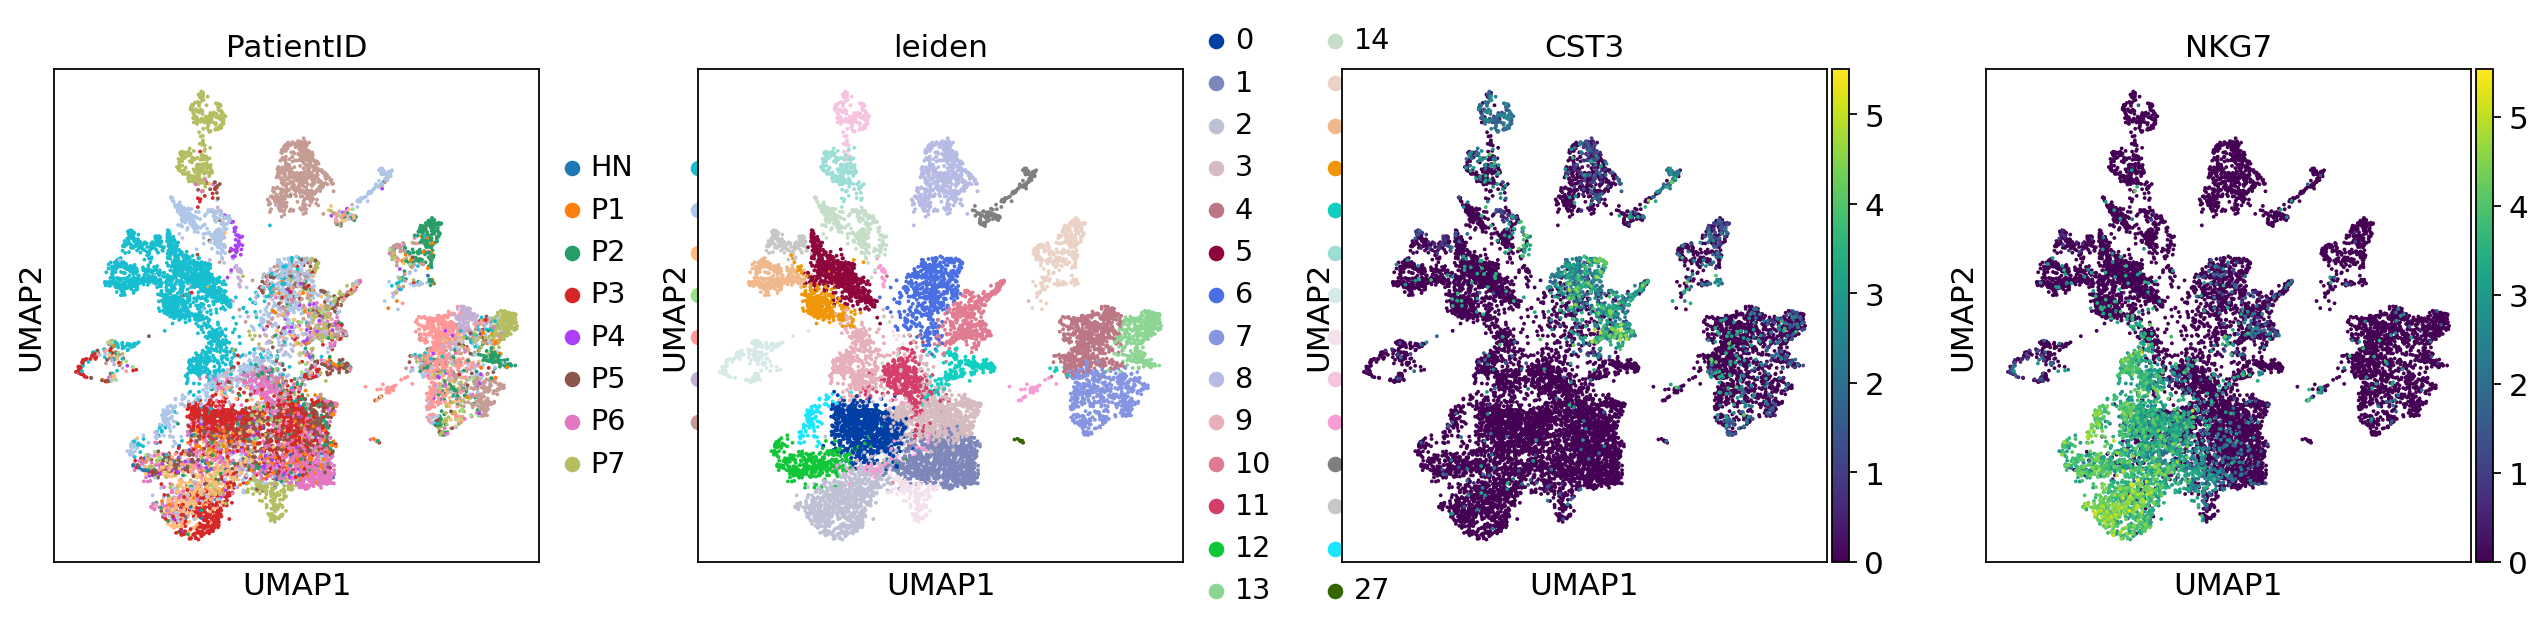

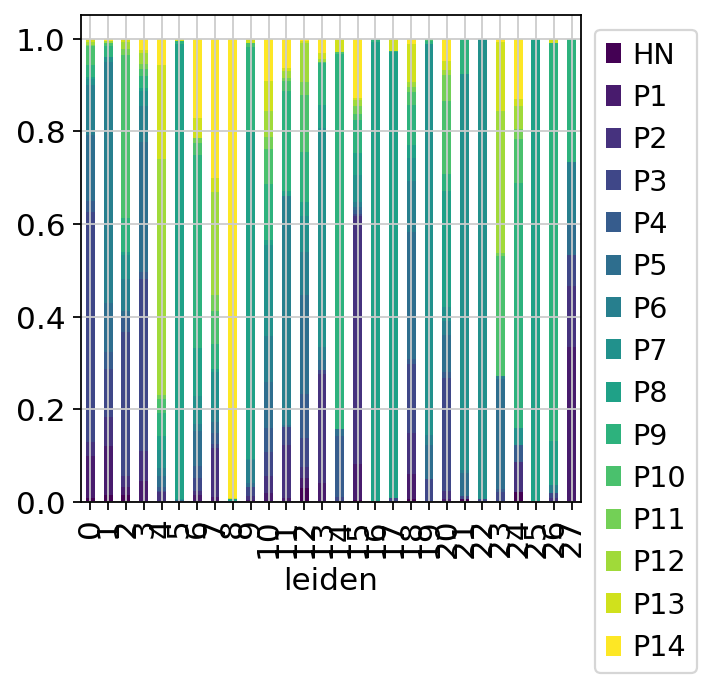

AnnData object with n_obs × n_vars = 10203 × 20263
    obs: 'PatientID', 'NormalvsTumor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
# Batch correction option: bbknn
adata = sc.read('adata3.h5ad')
sce.pp.bbknn(adata, 'PatientID')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

adata

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


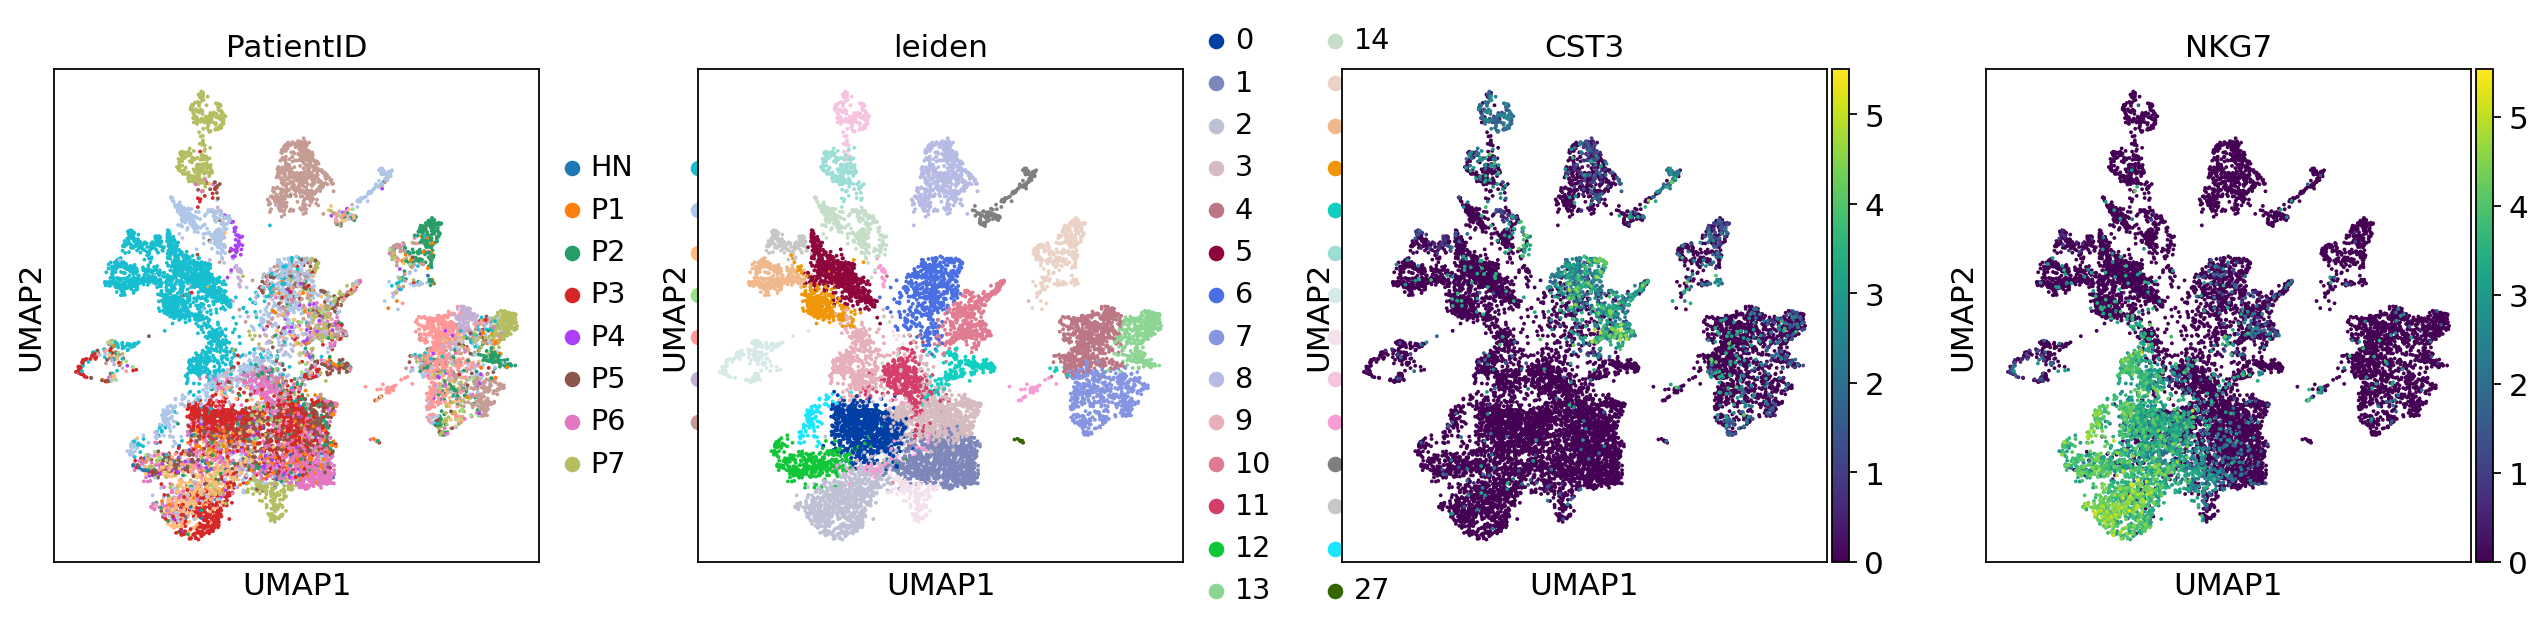

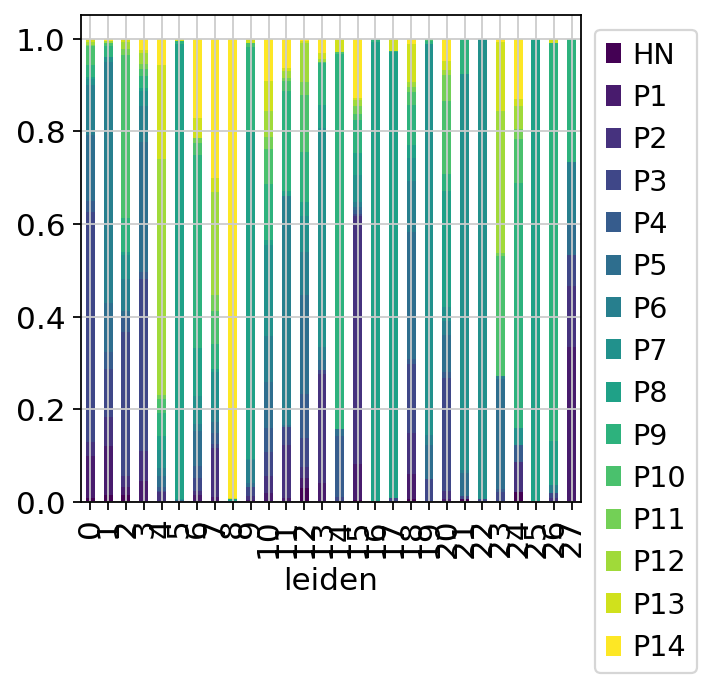

In [4]:
# Batch correction option: mnn
# It seems nothing changed.
adata = sc.read('adata3.h5ad')
sce.pp.mnn_correct(adata, batch_key='PatientID')
adata

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████████| 400/400 [11:33<00:00,  1.65s/it, v_num=1, train_loss_step=329, train_loss_epoch=320]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████| 400/400 [11:33<00:00,  1.73s/it, v_num=1, train_loss_step=329, train_loss_epoch=320]
computing neighbors
    finished (0:00:01)
running Leiden clustering
    finished (0:00:02)
computing UMAP
    finished (0:00:04)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


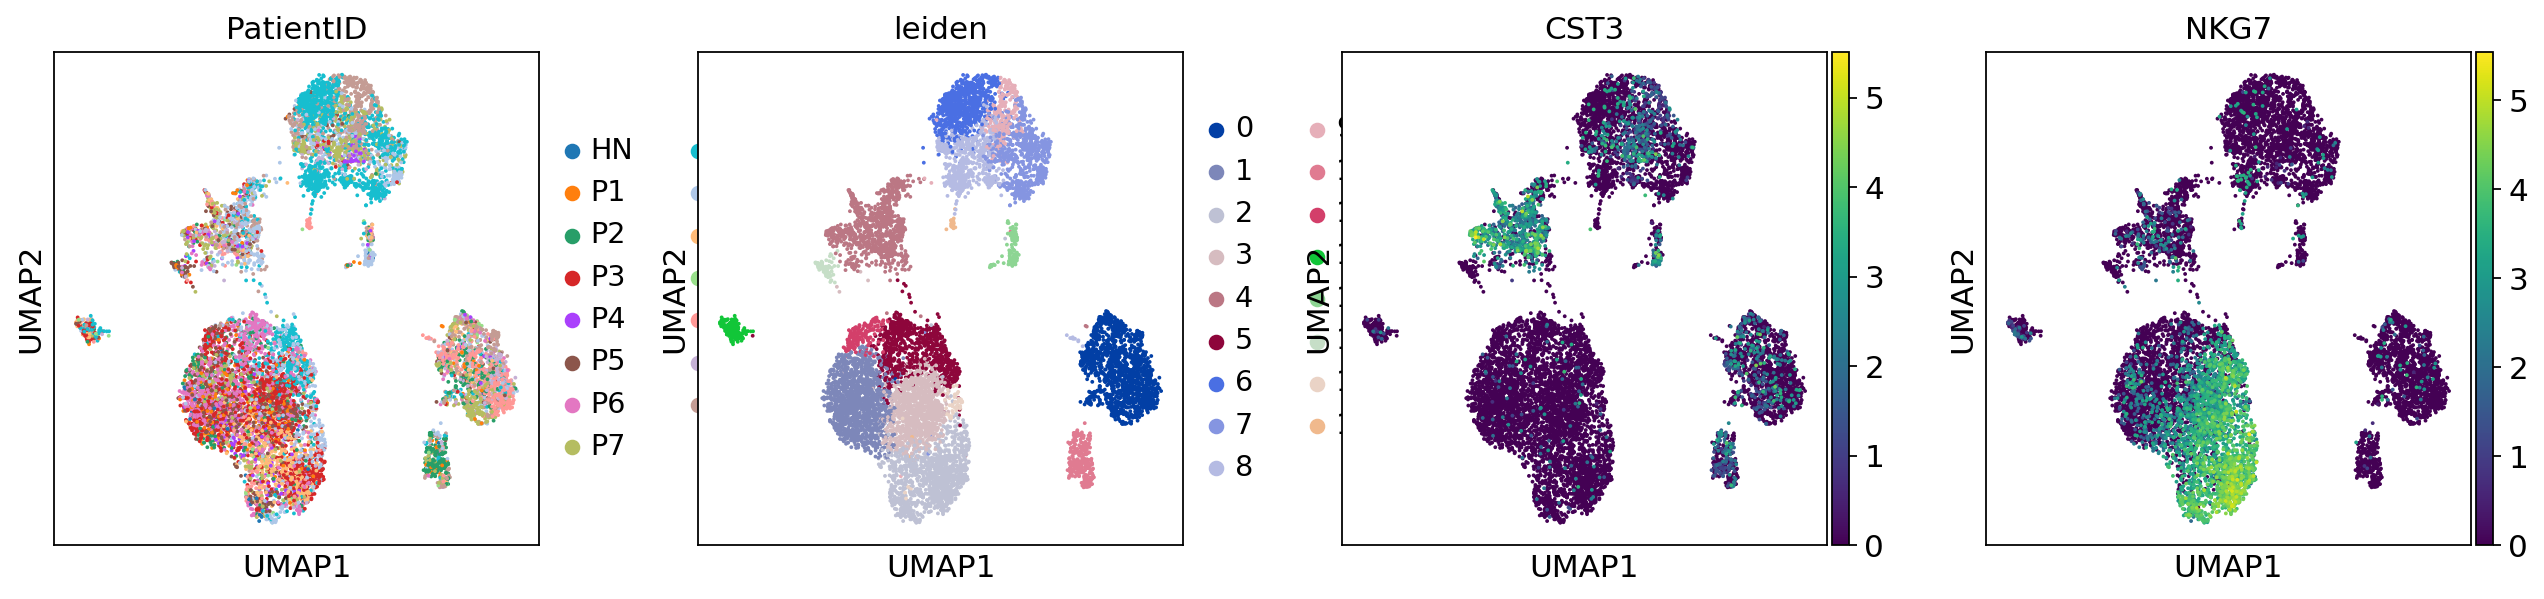

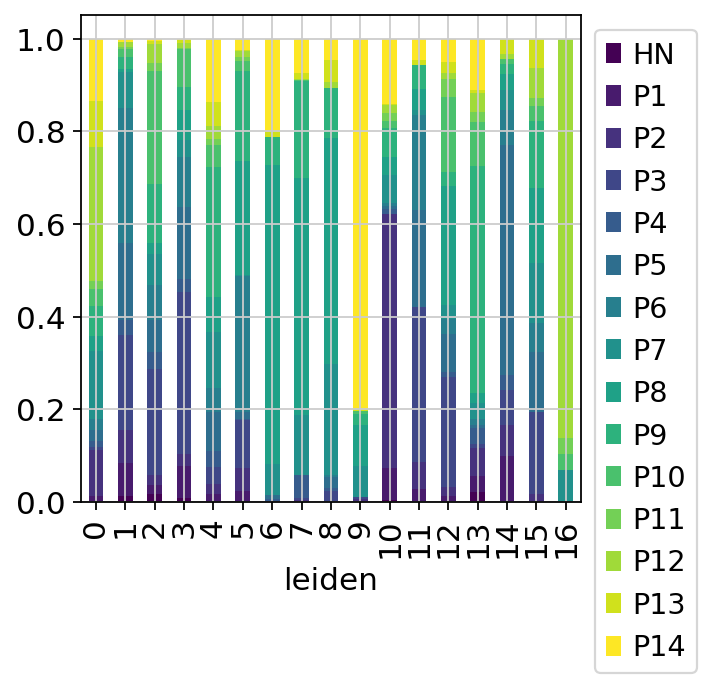

In [16]:
#Batch correction option: scvi tool
# Load the adata
# adata = sc.read('adata1_filtered_unnorm.h5ad')
adata = sc.read('adata3.h5ad')
adata

# Normalizaiton and log1p transformation: Not necessary if it is done
## sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="PatientID",
    span=0.8
)

# Set up scVI
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["PatientID"],
    continuous_covariate_keys=["pct_counts_mt"],
)

# Model training: it may take time
model = scvi.model.SCVI(adata)
model.train()

# Save the trained model
model.save("path_to_save_model/scvi_model")

# Get latent representation
latent = model.get_latent_representation()
adata.obsm['X_scVI'] = latent

# Use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

# Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

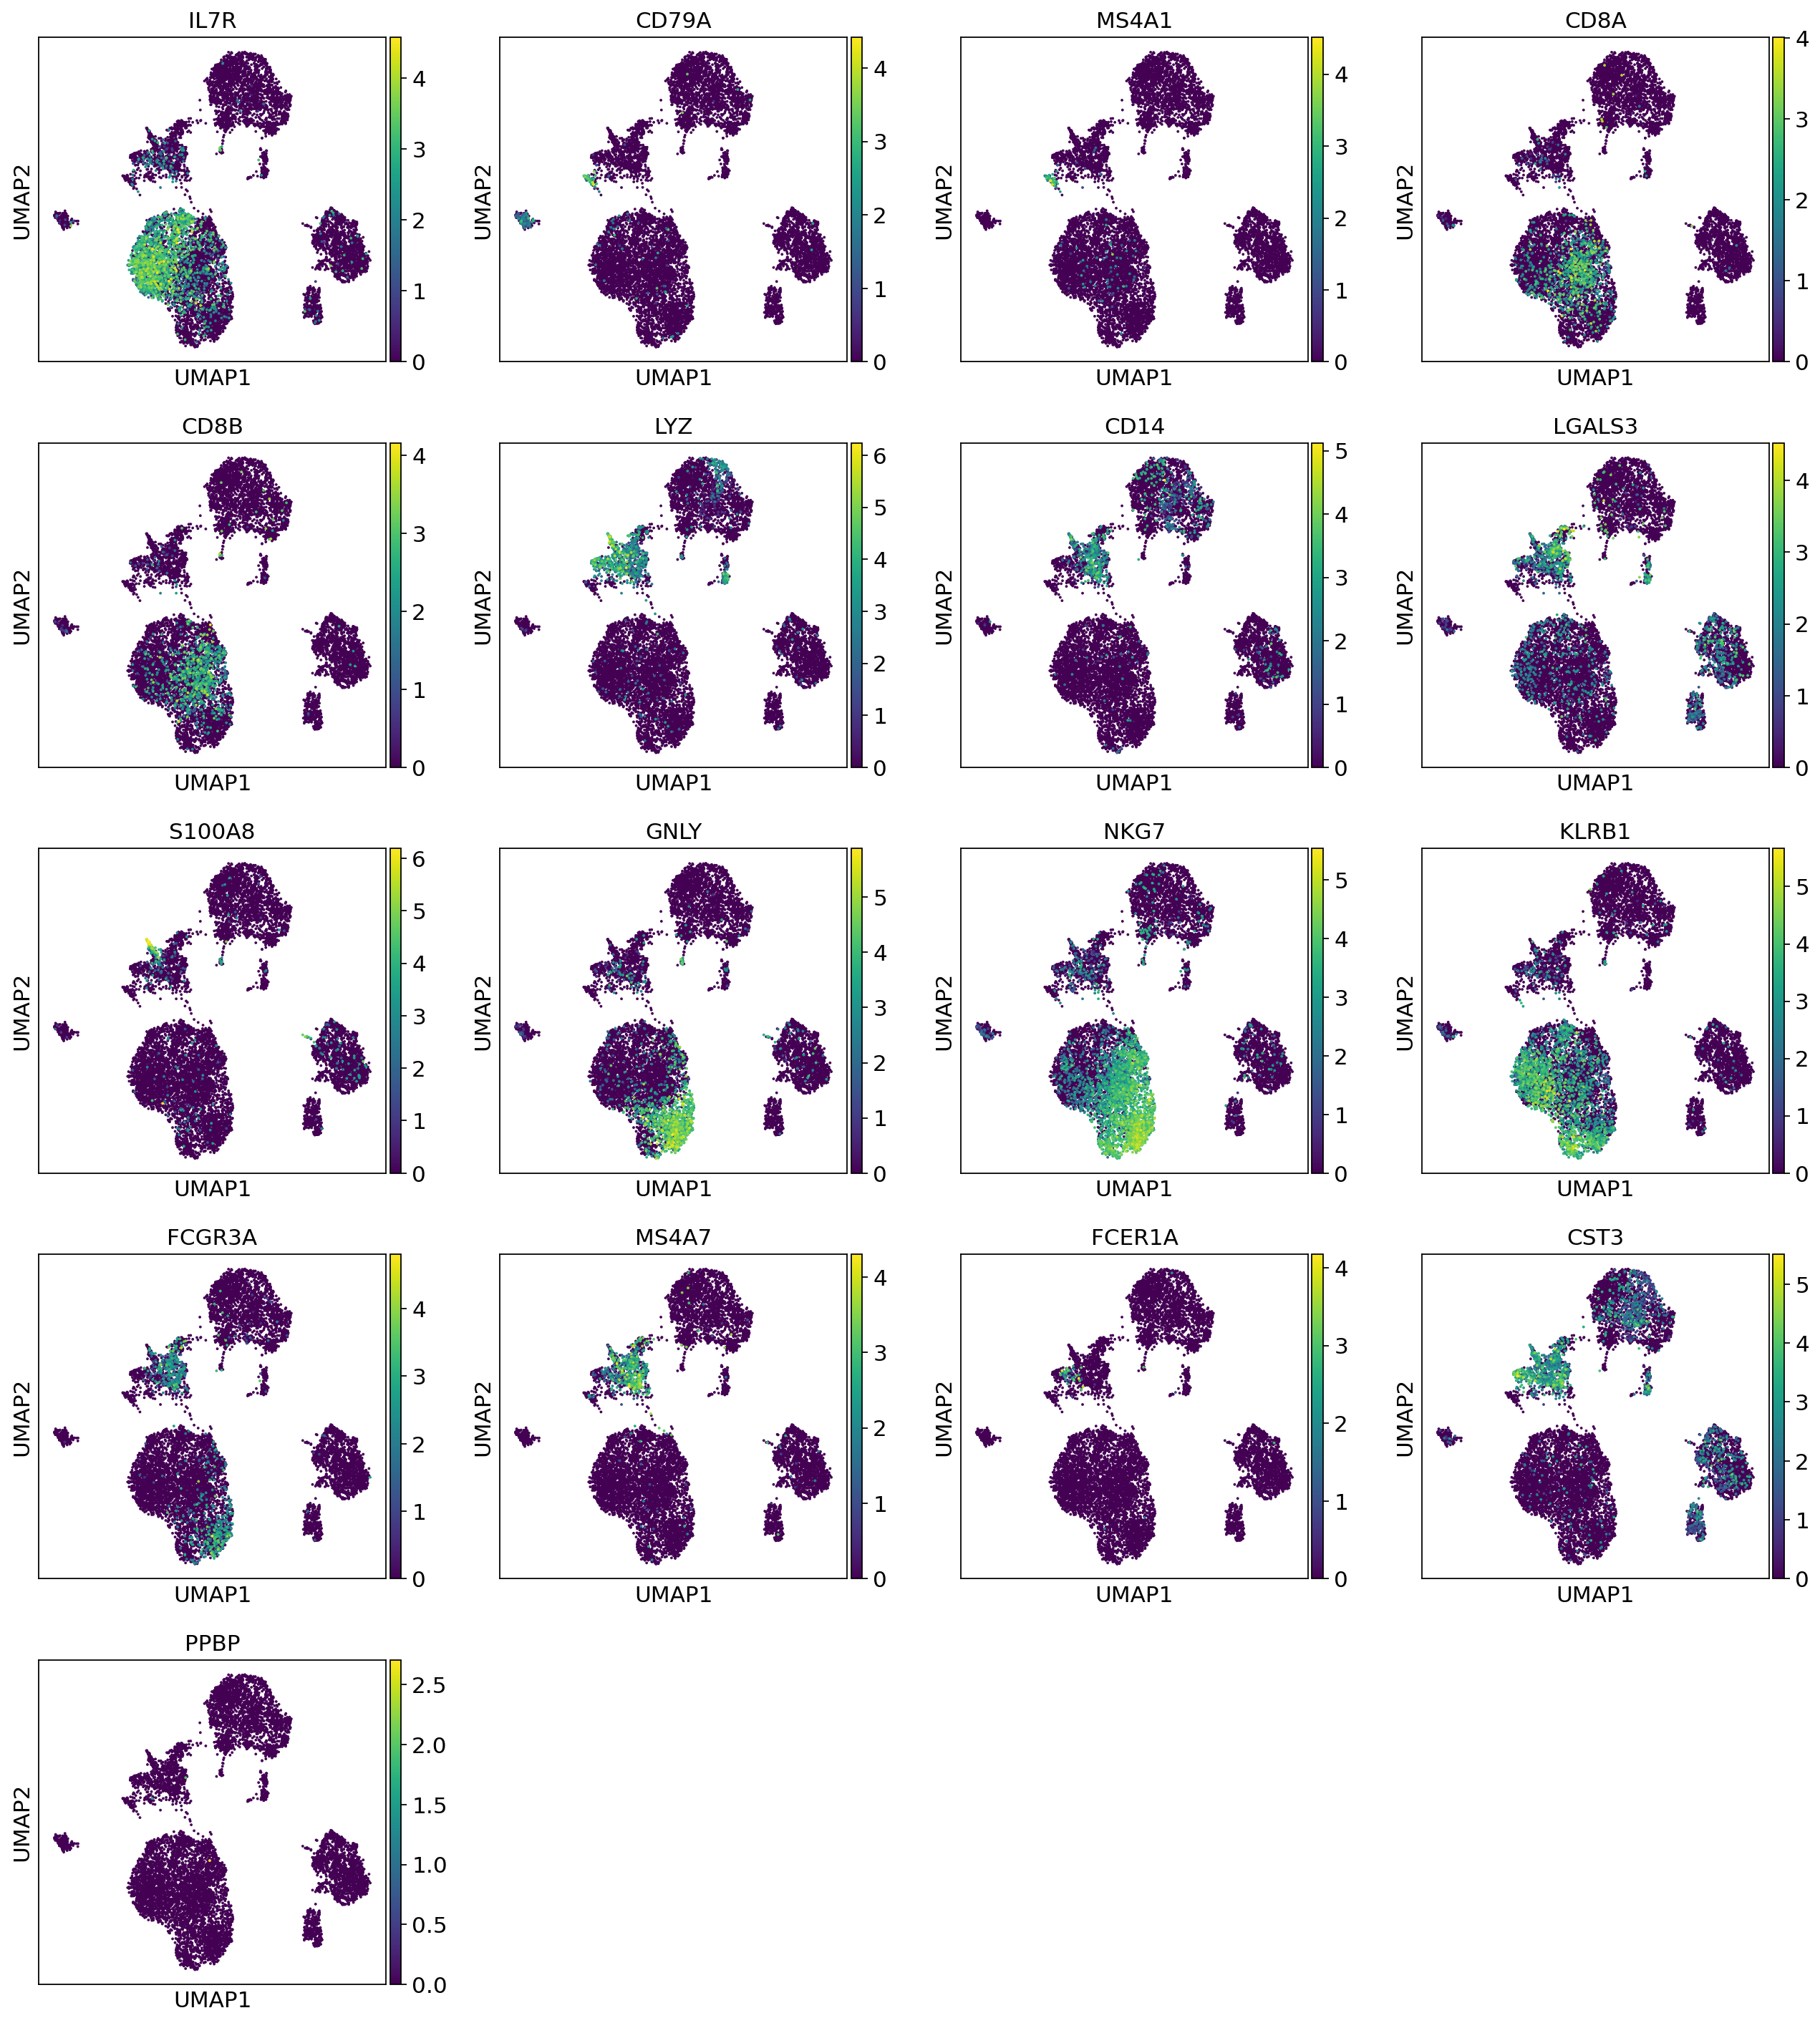

In [17]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

sc.pl.umap(adata, color=marker_genes)